In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad
import time

Useful function for the plot

In [2]:
def display_band(X, par,epsi=0.001,col='k'):
  x1 = np.min(X[0, :])
  x2 = np.max(X[0, :])
  y1 = np.min(X[1, :])
  y2 = np.max(X[1, :])

  # extend the line for the k# of its length 
  k = 0.01
  dx = x2-x1
  dy = y2-y1
  l = np.sqrt(dx**2+dy**2)
  x1 = x1 - k*l
  x2 = x2 + k*l
  y1 = y1 - k*l
  y2 = y2 + k*l
  ##
  if np.abs(par[1])<2e-2 :
      #disp('vertical line')
    a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
    b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
  else:
    a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
    b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

  if np.abs(par[0])<1e-5:
    v = np.array([0,1]) 
  else:    
    v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

  v = v / np.sqrt(np.sum(v**2));
  # corners of the bands
  v = v[:, np.newaxis]
  a1 = a - epsi * v;
  a2 = a + epsi * v;
  b1 = b - epsi * v;
  b2 = b + epsi * v;

  px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
  py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
  plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
  plt.gca().set_aspect('equal')

Function that computes the residual between points and a line

In [3]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2]) / np.sqrt(M[0] ** 2 + M[1] ** 2)
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i]) / np.sqrt(M[0, i] ** 2 + M[1, i] ** 2)
  return d

Implement the following function, that computes the solution of the overdetermined system

$$\underset{A}{\text{argmin}} \| A\mathbf x - \mathbf y\|_2^2$$

via OLS and DLT

The input $P=[[x_1, y_1], \dots,[x_N,y_N]]$ collects the points where the line $y = mx+q$ should pass through


In [4]:
def fit_line_ols(P):
  # design matrix
  A = np.c_[P[0, :], np.ones(P.shape[1])]
  # vector of responses 
  y = P[1, :]
  # straight line coefficient
  theta, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
  residuals = y - A @ theta;
  return theta

In [5]:
def fit_line_dlt(P):
  # design matrix
  A = np.c_[P.T, np.ones(P.shape[1])]
  
  # SVD
  _, _, VT = np.linalg.svd(A)
  
  theta = VT[-1]
  return theta

Robust Fitting Methods
----------------------
Implements the following methods:

In [6]:
def n_iter_RANSAC(eps, min_samples, p_outlier=0.1, p_success=0.99):
    niter = np.log(1 - p_success) / np.log(1 - (1 - p_outlier) ** min_samples)
    return (int)(niter + 1)

In [7]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1]
  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # set maximum number of iterations
  MaxIterations = n_iter_RANSAC(eps, cardmss, f, alpha)

  # set maximum consensus reached
  maxscore = 0
 
  for i in range(MaxIterations):
      
    # Generate cardmss random indices in the range 0..n-1
    mss = np.random.choice(n, cardmss, replace=False)
    
    # Fit model to this minimal sample set.
    theta = fit_line_dlt(X[:, mss])

    # Evaluate distances between points and model
    sqres = res_line(X, theta) ** 2

    # identify inliers: consensus set
    inliers = sqres < eps

    # assess consensus (the number of inliers)
    score = np.sum(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

  # Refinement step: fit model to all inliers
  theta = fit_line_dlt(X[:, bestinliers])
  return theta, bestinliers

In [8]:
def simpleMSAC(X, eps, cardmss = 2):
  n = X.shape[1]
  alpha = 0.99 # Desired probability of success
  f = 0.5 # Pessimistic estimate of inliers fraction

  # set maximum number of iterations
  MaxIterations = n_iter_RANSAC(eps, cardmss, f, alpha)

  # set maximum consensus reached
  mincost = np.inf

  for i in range(MaxIterations):
    # Generate cardmss random indices in the range 0..n-1
    mss = np.random.choice(n, cardmss, replace=False)

    # Fit model to this minimal sample set.
    theta = fit_line_dlt(X[:, mss])

    # Evaluate distances between points and model
    sqres = res_line(X, theta) ** 2

    # identify inliers: consensus set
    inliers = sqres <= eps

    # Compute MSAC score
    cost = np.sum(np.minimum(sqres[inliers], eps))

    # replace mincost, bestinliers and bestmodel if needed
    if cost < mincost:
      mincost = cost
      bestinliers = inliers
      bestmodel = theta

  # Refinement step: fit model to all inliers
  theta = fit_line_dlt(X[:, bestinliers])

  return theta, bestinliers

In [9]:
def simpleLMEDS(X, cardmss = 2):
  n = X.shape[1]
  alpha = 0.99 # Desired probability of success
  f = 0.5 # Pessimistic estimate of inliers fraction

  # set maximum number of iterations
  MaxIterations = n_iter_RANSAC(mad(X[1]) * 3, cardmss, f, alpha)

  # set maximum consensus reached
  mincost = np.inf

  for i in range(MaxIterations):
    # Generate cardmss random indicies in the range 0..n-1
    mss = np.random.choice(n, cardmss, replace=False)

    # Fit model to this minimal sample set.
    theta = fit_line_dlt(X[:, mss])

    # Evaluate distances between points and model
    sqres = res_line(X, theta) ** 2

    # Compute LMS score
    cost = np.median(sqres)

    # define inliner threshold (does make sense only when the model provides a good fit)
    # compute the standard deviation of distances (you can use MAD)
    scale = mad(sqres)

    # instead of 3-sigma rule, we do 2.5-sigma rule. sqres is already squares
    inliers = sqres < 2.5 * scale

    # replace mincost, bestinliers and bestmodel if needed
    if cost < mincost:
      mincost = cost
      bestinliers = inliers
      bestmodel = theta

    # Refinement step: fit model to all inliers
    theta = fit_line_dlt(X[:, bestinliers])

  return theta, bestinliers

Fitting over noisy data
-----------------------
Set the parameters and generate the dataset

In [10]:
cardmss = 2          # minimum number of points required to fit a model

# plotting params
BAND_WIDTH = 0.05
BAND_COLOR = 'b'

# create noisy dataset
x = np.linspace(0,1,100)
y = 1.5 * x + 1;
X = np.vstack((x, y))
sigma = 0.01;
X = X + sigma * np.random.normal(size=X.shape)

In [11]:
X.shape

(2, 100)

Least square fit to noisy data

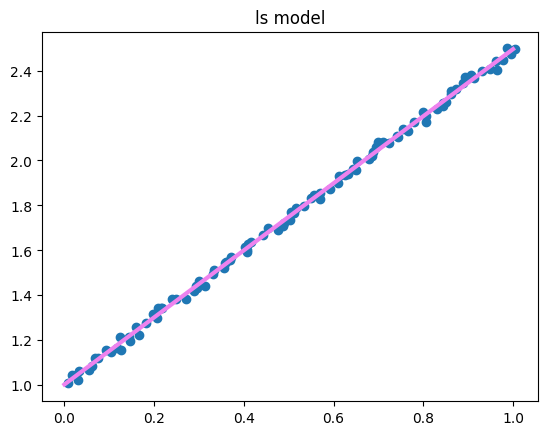

In [12]:
model_OLS = fit_line_ols(X)
plt.figure()
plt.scatter(X[0,:], X[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square fit via DLT (different model parametrization)

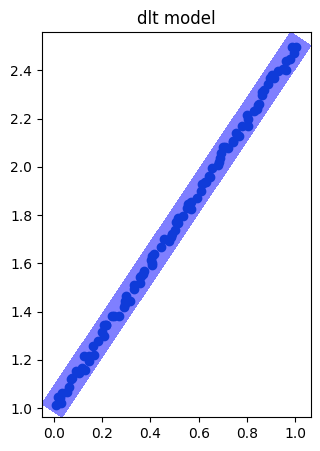

In [13]:
model_DLT = fit_line_dlt(X)
plt.figure(figsize = (15,5))
plt.scatter(X[0,:], X[1,:])
display_band(X, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('dlt model')
plt.show()

Add a single outlier to the data, obtaining a new dataset $X_{out}$

In [14]:
X_out = np.c_[X, np.array([1, 0.5])]
X_out.shape

(2, 101)

Least square fit to noisy data with a single outlier

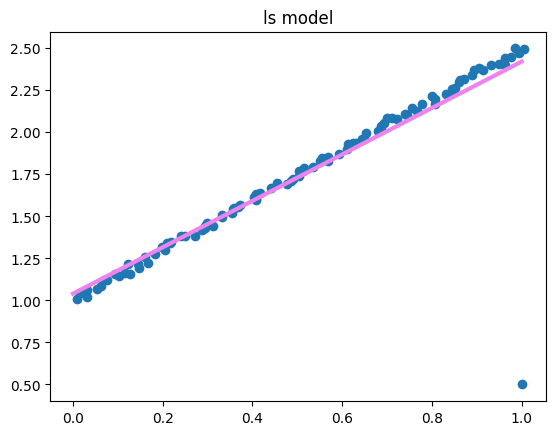

In [15]:
model_OLS = fit_line_ols(X_out)
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square fit via DLT to noisy data with a single outlier

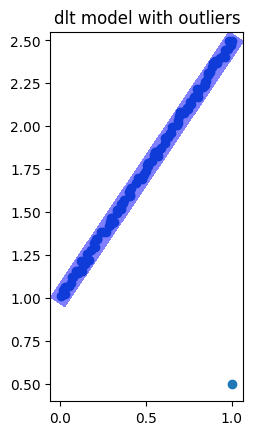

In [16]:
model_DLT = fit_line_dlt(X_out)
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('dlt model with outliers')
plt.show()

Add many outliers to the noisy data

In [17]:
n_out = 50
X_out = np.c_[X, np.random.rand(2, n_out)]

Least square fit

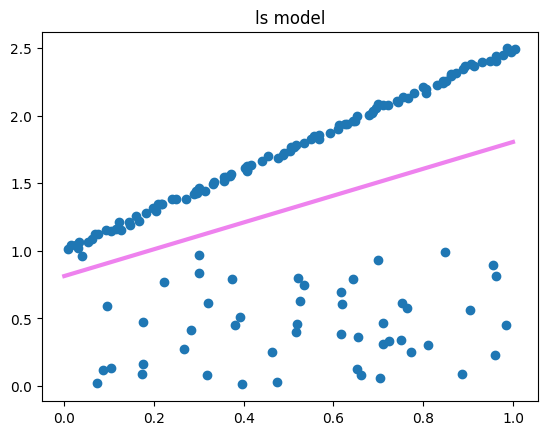

In [18]:
model_OLS = fit_line_ols(X_out)
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square via DLT

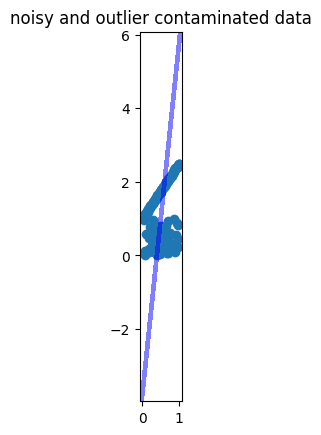

In [19]:
model_DLT = fit_line_dlt(X_out)
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('noisy and outlier contaminated data')
plt.show()

Robust Fitting methods
----------------------
Use Ransac, M-Sac and L-Meds to perform fitting on data with many outliers

Ransac:


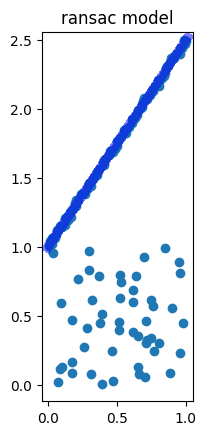

In [20]:
epsi = 3 * sigma # define inlier threshold

# invoke simpleRANSAC
bestmodel, bestinliers = simpleRANSAC(X_out, epsi, cardmss)

# refine model estimates
refinedModel = bestmodel # ALREADY REFINED

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('ransac model')
plt.show()

M-Sac:

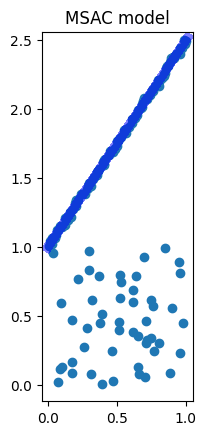

In [21]:
bestmodel, bestinliers = simpleMSAC(X_out, epsi, cardmss)

# refine model estimates
refinedModel = bestmodel # ALREADY REFINED

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('MSAC model')
plt.show()

L-Meds:

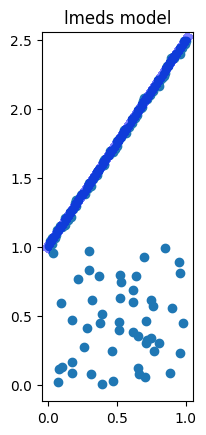

In [22]:
# invoke simpleLMEDS
bestmodel, bestinliers = simpleLMEDS(X_out, cardmss)

# refine model estimates
refinedModel = bestmodel # ALREADY REFINED

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('lmeds model')
plt.show()